In [1]:
# import library
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Models import Model
import warnings

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import  TensorDataset, DataLoader

import ignite
from ignite.engine import Engine, Events
from ignite.metrics import Loss, RunningAverage, MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan, ProgressBar

warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

c:\Users\Afan Ramadhan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
# import tourist dataset
df = pd.read_csv("Dataset/tourism_rating.csv")

## **Exploratory Data Analysis**

### Check Basic Dataset Information

In [3]:
# cek 5 data pertama dalam dataset
df.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [4]:
# cek nama kolom yang terdapat pada dataset
df.columns

Index(['User_Id', 'Place_Id', 'Place_Ratings'], dtype='object')

In [5]:
# melihat informasi dasar dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [6]:
# melihat jumlah nilai unik pada setiap kolom
df.nunique()

User_Id          300
Place_Id         437
Place_Ratings      5
dtype: int64

### Check Missing Data

In [7]:
# melihat jumlah nilai kosong pada setiap kolom
df.isna().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

## **Data Preparation**

In [8]:
# mengambil nilai unik kolom User_Id dan Place_Id
user_ids = df['User_Id'].unique().tolist()
place_ids = df['Place_Id'].unique().tolist()

In [9]:
# encoding kolom User_Id dan Place_Id
user_ids_encoded = {id: i for i, id in enumerate(user_ids)}
place_ids_encoded = {id: i for i, id in enumerate(place_ids)}

In [10]:
# membuat kolom baru yang berisi hasil encoding kolom User_Id dan Place_Id
df['user'] = df['User_Id'].map(user_ids_encoded)
df['place'] = df['Place_Id'].map(place_ids_encoded)

In [11]:
# menghitung jumlah nilai unik kolom User_Id dan Place_Id
len_users = len(user_ids_encoded)
len_place = len(place_ids_encoded)

In [12]:
# mengubah tipe data kolom Place_Ratings menjadi float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# mencari nilai minimum dan maksimum dari kolom Place_Ratings
min_rating = min(df['Place_Ratings'])
max_rating = max(df['Place_Ratings'])

# menampilkan jumlah user, jumlah destinasi wisata, rating minimal dan rating maksimal
print("Count of Users: {} | Count of Place: {} | Min Rating: {} | Max Rating: {}"
      .format(len_users, len_place, min_rating, max_rating))

Count of Users: 300 | Count of Place: 437 | Min Rating: 1.0 | Max Rating: 5.0


In [13]:
# menampilkan dataset yang sudah diubah
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
0,1,179,3.0,0,0
1,1,344,2.0,0,1
2,1,5,5.0,0,2
3,1,373,3.0,0,3
4,1,101,4.0,0,4


### Data Splitting

In [14]:
# mengambil nilai fitur dan target
X = df[['user', 'place']].values
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [15]:
# memisahkan data untuk training dan testing
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8000, 2), (2000, 2), (8000,), (2000,))

In [16]:
# mengubah tipe data ke tensor
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [17]:
# membuat dataset train dan test untuk model neural network
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

# membuat dataloader dengan batch size 32
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## **Modeling**

### Define Model

In [18]:
# mendefinisikan model 
model = Model.NeuralCollaborativeModel(len_users, len_place, embedding_size=100)
model = model.to(device)

# mendefinisakan loss function dan optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

### Training Process

In [19]:
# fungsi untuk proses training
def training_step(engine, batch):
    feature, target = batch[0].to(device), batch[1].to(device)
    model.train()
    user, place = feature[:, 0], feature[:, 1]
    y_pred = model(user, place)
    loss = criterion(y_pred, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    engine.state.metrics["train_loss"] = loss.item()
    return {"train_loss": loss.item()}

In [20]:
# mendefinisikan engine untuk proses training
trainer = Engine(training_step)

# menghitung nilai running rata-rata metrik yang digunakan 
def output_transform(metric):
    return metric["train_loss"]
RunningAverage(output_transform=output_transform).attach(trainer, "train_loss")

# menambahkan TerminateOnNan ke event: menghentikan training jika output bernilai NaN
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

### Validation & Testing Process

In [21]:
# fungsi untuk proses testing
def validation_step(engine, batch):
    feature, target = batch[0].to(device), batch[1].to(device)
    model.eval()
    with torch.no_grad():
        user, place = feature[:, 0], feature[:, 1]
        y_pred = model(user, place)
        return y_pred, target

In [22]:
# mendefinisikan engine untuk proses validasi dan testing
train_evaluator = Engine(validation_step)
evaluator = Engine(validation_step)

# mendefinisikan metrik yang digunakan
metrics = {
    "MAE": MeanAbsoluteError(device=device),
    "loss": Loss(criterion, device=device),
    "MSE": MeanSquaredError(device=device),
    "RMSE": RootMeanSquaredError(device=device)
}

# menambahkan metrik ke dalam engine evaluator
for name, metric in metrics.items():
    metric.attach(train_evaluator, name)
    metric.attach(evaluator, name)

### Log Train & Test Model

In [23]:
# menyimpan nilai metrik pada setiap epoch kedalam dictionary
log_train_val_metric = {"mae": [], "mse": [], "rmse": [], "loss": []}
log_test_metric = {"mae": [], "mse": [], "rmse": [], "loss": []}

# fungsi untuk log/melacak hasil validasi pada setiap epoch
def log_train_evaluation(engine):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics["loss"]
    mae = metrics["MAE"]
    mse = metrics["MSE"]
    rmse = metrics["RMSE"]
    log_train_val_metric["mae"].append(mae)
    log_train_val_metric["loss"].append(loss)
    log_train_val_metric["mse"].append(mse)
    log_train_val_metric["rmse"].append(rmse)

# fungsi untuk log/melacak hasil testing pada setiap epoch    
def log_test_evaluation(engine):
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    loss = metrics["loss"]
    mae = metrics["MAE"]
    mse = metrics["MSE"]
    rmse = metrics["RMSE"]
    log_test_metric["mae"].append(mae)
    log_test_metric["loss"].append(loss)
    log_test_metric["mse"].append(mse)
    log_test_metric["rmse"].append(rmse)

# menambahkan fungsi ke engine setiap satu epoch proses training selesai dilakukan
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_train_evaluation)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_test_evaluation)

In [24]:
# membuat tqdm bar untuk visualisasi selama proses training
ProgressBar(bar_format="").attach(trainer,
                                  metric_names=['train_loss', 'lr'])

ProgressBar(persist=True, bar_format="").attach(trainer,
                                  metric_names=["train_loss", "lr"],
                                  event_name=Events.EPOCH_STARTED,
                                  closing_event_name=Events.EPOCH_COMPLETED)

### Learning Rate Scheduler

In [25]:
# membuat learning rate scheduler untuk fine tunning
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
trainer.add_event_handler(Events.EPOCH_COMPLETED, lambda engine: lr_scheduler.step())

# log/melacak nilai laerning rate setiap epoch 
def log_lr(engine):
    lr = optimizer.param_groups[0]["lr"]
    engine.state.metrics["lr"] = lr    
trainer.add_event_handler(Events.ITERATION_COMPLETED, log_lr)

### EarlyStopping

In [26]:
# fungsi untuk mengambil nilai loss
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

# earlystopping dengan patience 5 berdasarkan nilai loss
patience = 5
early_stopping = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, early_stopping)

### Model Checkpoint

In [27]:
# menyimpan model terbaik ke dalam file
def score_function(engine):
    val_loss = engine.state.metrics['MAE']
    return val_loss

checkpoint = ModelCheckpoint(
    dirname="./Save_Models",
    filename_prefix="best", 
    n_saved=1, 
    create_dir=True,
    score_name="mae", 
    score_function=score_function,
    require_empty=False
)

evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {"model": model})

### Run Engine

In [28]:
# running proses training menggunakan 100 epoch
EPOCH = 100

trainer.run(train_loader, max_epochs=EPOCH)

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<?, ?it/s]

2025-04-13 12:25:22,072 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 5750
	epoch: 23
	epoch_length: 250
	max_epochs: 100
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [29]:
# hasil akhir pada data validasi
train_evaluator.state.metrics

{'MAE': 0.29253866577148435,
 'loss': 0.11944570159912109,
 'MSE': 0.11724694061279296,
 'RMSE': 0.34241340600623826}

In [30]:
# hasil akhir pada data testing
evaluator.state.metrics

{'MAE': 0.2934969177246094,
 'loss': 0.11853000640869141,
 'MSE': 0.11816599273681641,
 'RMSE': 0.34375280760572186}

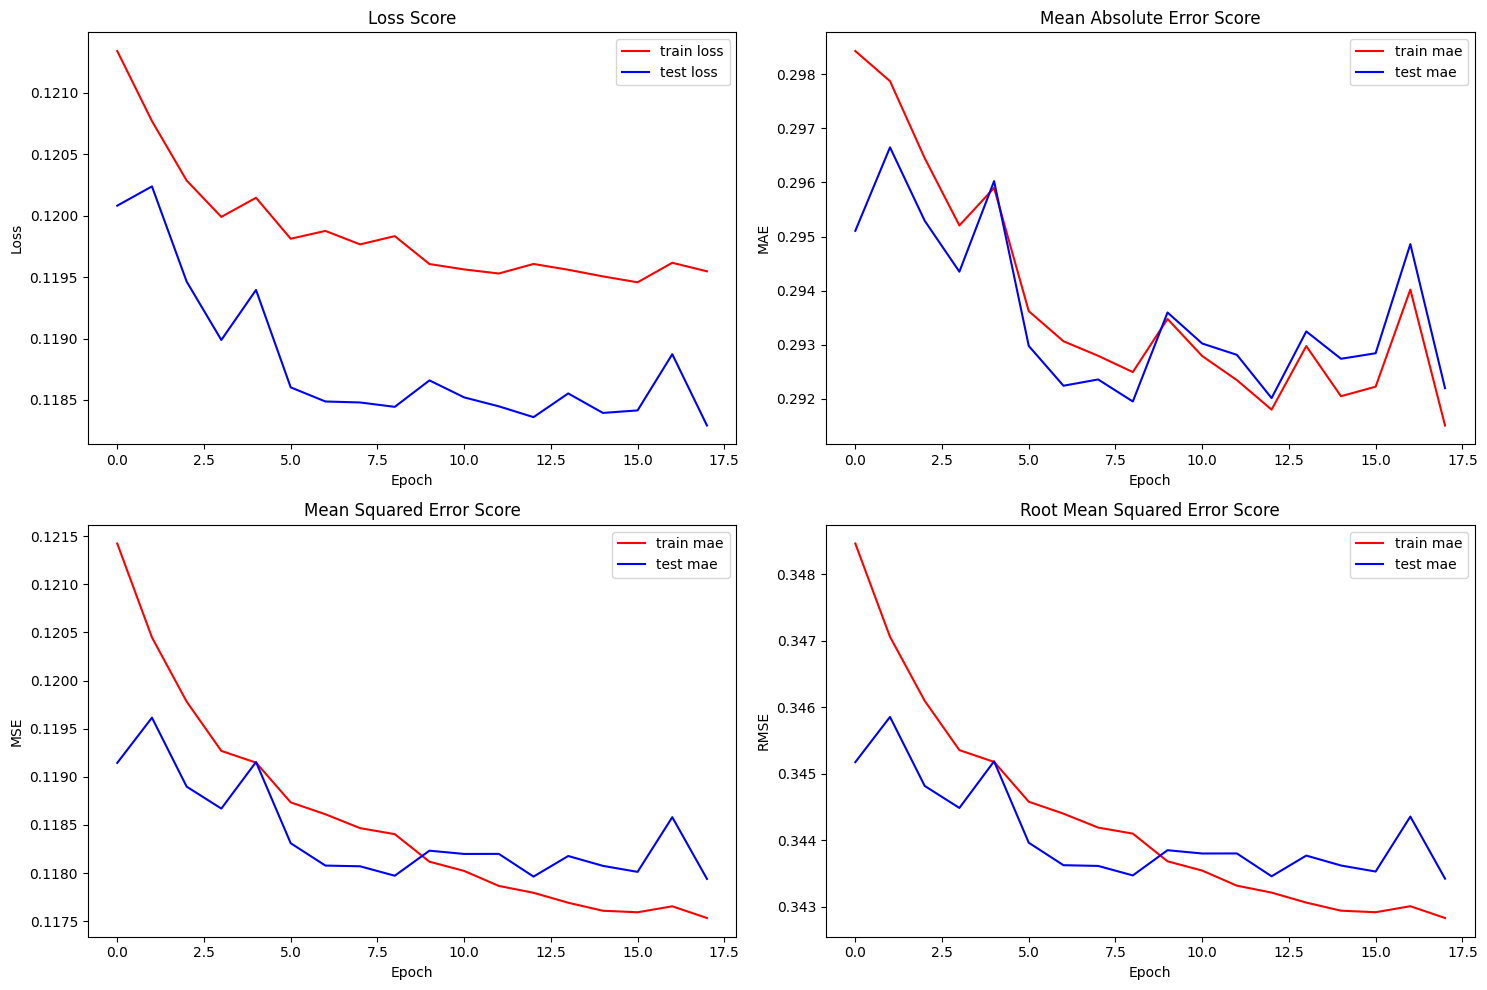

In [31]:
# visualisasi metrik setiap epoch
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

# Loss Score
ax[0].plot(log_train_val_metric["loss"][:-patience], c='r', label="train loss")
ax[0].plot(log_test_metric["loss"][:-patience], c='b', label="test loss")
ax[0].set_title("Loss Score")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Mean Absolute Error Score
ax[1].plot(log_train_val_metric["mae"][:-patience], c='r', label="train mae")
ax[1].plot(log_test_metric["mae"][:-patience], c='b', label="test mae")
ax[1].set_title("Mean Absolute Error Score")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("MAE")
ax[1].legend()

# Mean Squared Error Score
ax[2].plot(log_train_val_metric["mse"][:-patience], c='r', label="train mae")
ax[2].plot(log_test_metric["mse"][:-patience], c='b', label="test mae")
ax[2].set_title("Mean Squared Error Score")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("MSE")
ax[2].legend()

# Root Mean Squared Error Score
ax[3].plot(log_train_val_metric["rmse"][:-patience], c='r', label="train mae")
ax[3].plot(log_test_metric["rmse"][:-patience], c='b', label="test mae")
ax[3].set_title("Root Mean Squared Error Score")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("RMSE")
ax[3].legend()

fig.tight_layout()
fig.show()

## **Inference**

In [32]:
# fungsi untuk mencari model terbaik yang telah disimpan
def last_checkpoint_filename(path_name):
    filename = os.listdir(path_name)
    models = [x for x in filename if x.endswith(".pt")]
    checkpoint_iter = [float(z.split("_")[2].split('=')[1].replace(".pt", "")) for z in models]
    idx = np.array(checkpoint_iter).argmax()
    return Path(path_name + models[idx])

load_modelcheckpoint = last_checkpoint_filename("./Save_Models/")
load_modelcheckpoint

WindowsPath('Save_Models/best_model_mae=0.2966.pt')

In [33]:
# load model yang disimpan
loaded_model = model
loaded_model.load_state_dict(torch.load(load_modelcheckpoint,weights_only=True))

<All keys matched successfully>

In [34]:
# fungsi untuk proses inferensi
def inference_step(engine, batch):
    global inference_items
    model.eval()
    with torch.inference_mode():
        feature, target = batch[0].to(device), batch[1].to(device)
        user, place = feature[:, 0], feature[:, 1]
        y_pred = loaded_model(user, place)
        output = {"feature": feature, "target": target, "preds": torch.argmax(y_pred, dim=1)}
        engine.state.metrics = output
        return y_pred, target

In [35]:
# mendefinisikan engine untuk proses inferensi
inferencer = Engine(inference_step)

# menambahkan metrik ke dalam engine inference
for name, metric in metrics.items():
    metric.attach(inferencer, name)

In [36]:
#  log dan running proses inferensi
ProgressBar(desc="Inference").attach(inferencer)

inferencer.run(test_loader, max_epochs=1)

Inference[1/63]   2%|1          [00:00<?]

State:
	iteration: 63
	epoch: 1
	epoch_length: 63
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [37]:
# menampilkan nilai metrik 
mae = inferencer.state.metrics['MAE']
mse = inferencer.state.metrics['MSE']
rmse = inferencer.state.metrics['RMSE']

print(f"Mean Absolute Error     : {mae:.4f}")
print(f"Mean Squared Error      : {mse:.4f}")
print(f"Root Mean Squared Error : {rmse:.4f}")


Mean Absolute Error     : 0.2966
Mean Squared Error      : 0.1196
Root Mean Squared Error : 0.3459
